# Exercise 3 (Leakage detection with surrogate models and Bayesian inversion)

Our purpose, here, is to come up with an efficient algorithm that can rapidly detect potential water leaks based on real-time measurements of the pressure field. To simplify, we consider a 2D section of a cylindrical cistern, consisting of a main core,

$R := \{(x,y) : x^2 + y^2 \leq 0.5^2\} \subset \mathbb{R}^2,$

surrounded by an emergency wall,

$\Gamma = \{(x,y) : x^2 + y^2 = 1\}.$

We refer to Figure 3 for a visual representation. In order to develop suitable safety measures, we are interested in studying the worst-case scenario, that is, the unfortunate event in which water manages to break out of both the reservoir and the emergency wall. We use the steady Navier-Stokes equations to model the fluid flow, ideally capturing the scenario a few minutes after the break has occurred.

Let

$\Omega = \{(x,y) : 0.5^2 < x^2 + y^2 < 1\}$

be the interspace between the reservoir and the emergency wall.

Let $\mathbf{u} : \Omega \to \mathbb{R}^2$ and $p : \Omega \to \mathbb{R}$ be the velocity field and the pressure field of the fluid, respectively. Let $z_1 \in \partial R$ and $z_2 \in \Gamma$ be the break points on the two surfaces, respectively. Let $\rho_1, \rho_2 > 0$ describe the width of the two openings, respectively centered at $z_1$ and $z_2$. We model $\mathbf{u}$ and $p$ as the solution to the following Navier-Stokes equations:

$$
\begin{cases}
-\Delta \mathbf{u} + \mathbf{u} \cdot \nabla \mathbf{u} - \nabla p = 0, & \text{in } \Omega \\
\nabla \cdot \mathbf{u} = 0, & \text{in } \Omega \\
\mathbf{u} = 0, & \text{on } \partial \Omega
\end{cases}
$$

with boundary conditions,

$$
\begin{cases}
\mathbf{u}(x,y) = \begin{bmatrix} \frac{1}{4} + y^2 - \rho_1^2 \\ 0 \end{bmatrix}, & \forall (x,y) \in R : \| (x,y) - z_1 \| < \rho_1 \\
p(x,y) = 0, & \forall (x,y) \in \Gamma : \| (x,y) - z_2 \| < \rho_2 \\
\mathbf{u} = 0, & \text{elsewhere on } \partial \Omega.
\end{cases}
$$

modeling inflow, outflow, and no-slip conditions, respectively. Given all the rotational symmetries enjoyed by Eqs. (6)-(7), we shall fix the position of the first break point,

$$
z_1 := [0.5, 0].
$$

Instead, we allow $z_2, \rho_1, \rho_2$ to change as

$$
0.05 \leq \rho_i \leq 0.1, \quad z_2 = [\cos \theta, \sin \theta]^\top \text{ with } \theta \in [0, \pi].
$$


Let $\boldsymbol{\mu} := [\theta, \rho_1, \rho_2]^\top$ be the problem parameters. You are given access to a dataset of $N = 200$ pre-computed random simulations of the pressure field, obtained for different values of the problem parameters, $\{\boldsymbol{\mu}_i, \mathbf{p}_{\boldsymbol{\mu}_i} \}_{i=1}^{N}$. The dataset was constructed by drawing random values for $\boldsymbol{\mu}$ (independently and uniformly in the parameter space) and then solving (6) using a Finite Element solver. Only the pressure field were stored, with each PDE solution being represented as a discrete vector, $\mathbf{p}_{\boldsymbol{\mu}_i} = p_{\boldsymbol{\mu}_i}$, with $N_h = 3899$ degrees of freedom.  

Additionally, you are also given access to a dataset of 8 sensor measurements coming from an unknown pressure field $p_* : \Omega \to \mathbb{R}$. These correspond to pressure values recorded at the outer boundary,  

$$
[s_1, \dots, s_8] = [p_*(x_1, y_1), \dots, p_*(x_8, y_8)]
$$  

with $(x_k, y_k) = (\cos \frac{k \pi}{4}, \sin \frac{k \pi}{4})$. Ideally, we would like to use the simulations provided and the sensor measurements to solve the inverse problem, that is, to recover the values $\theta, \rho_1, \rho_2$ associated to $[s_1, \dots, s_8]^\top$. If we succeed, we will be able to estimate the position and the width of a water leak using as little as 8 sensor measurements.  


### Code from auxiliary notebook

In [1]:
try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

from IPython.display import clear_output as clc
import numpy as np
import matplotlib.pyplot as plt
import gdown

In [2]:
# Data
gdown.download(id = "1PrQyfLv3Sjv8oOgZk48MR-miDAq0X4pO", output = "leak_mesh.xml")
mesh = fe.loadmesh("leak_mesh.xml")
Vh = fe.space(mesh, 'CG', 1)

gdown.download(id = "1eEtqZPjLe3xPed15ckTAGNBYDQ8px8aJ", output = "leak_data.npz")
dataset = np.load("leak_data.npz")


Downloading...
From (original): https://drive.google.com/uc?id=1PrQyfLv3Sjv8oOgZk48MR-miDAq0X4pO
From (redirected): https://drive.google.com/uc?id=1PrQyfLv3Sjv8oOgZk48MR-miDAq0X4pO&confirm=t&uuid=62605b51-e35e-4b07-be0d-fb26e7bf439e
To: /content/leak_mesh.xml
100%|██████████| 773k/773k [00:00<00:00, 96.6MB/s]

Calling FFC just-in-time (JIT) compiler, this may take some time.



Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00382376 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.392422 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:---------------------------

In [3]:
mu, pressure = dataset['mu'], dataset['u']
clc()

<Figure size 400x400 with 0 Axes>

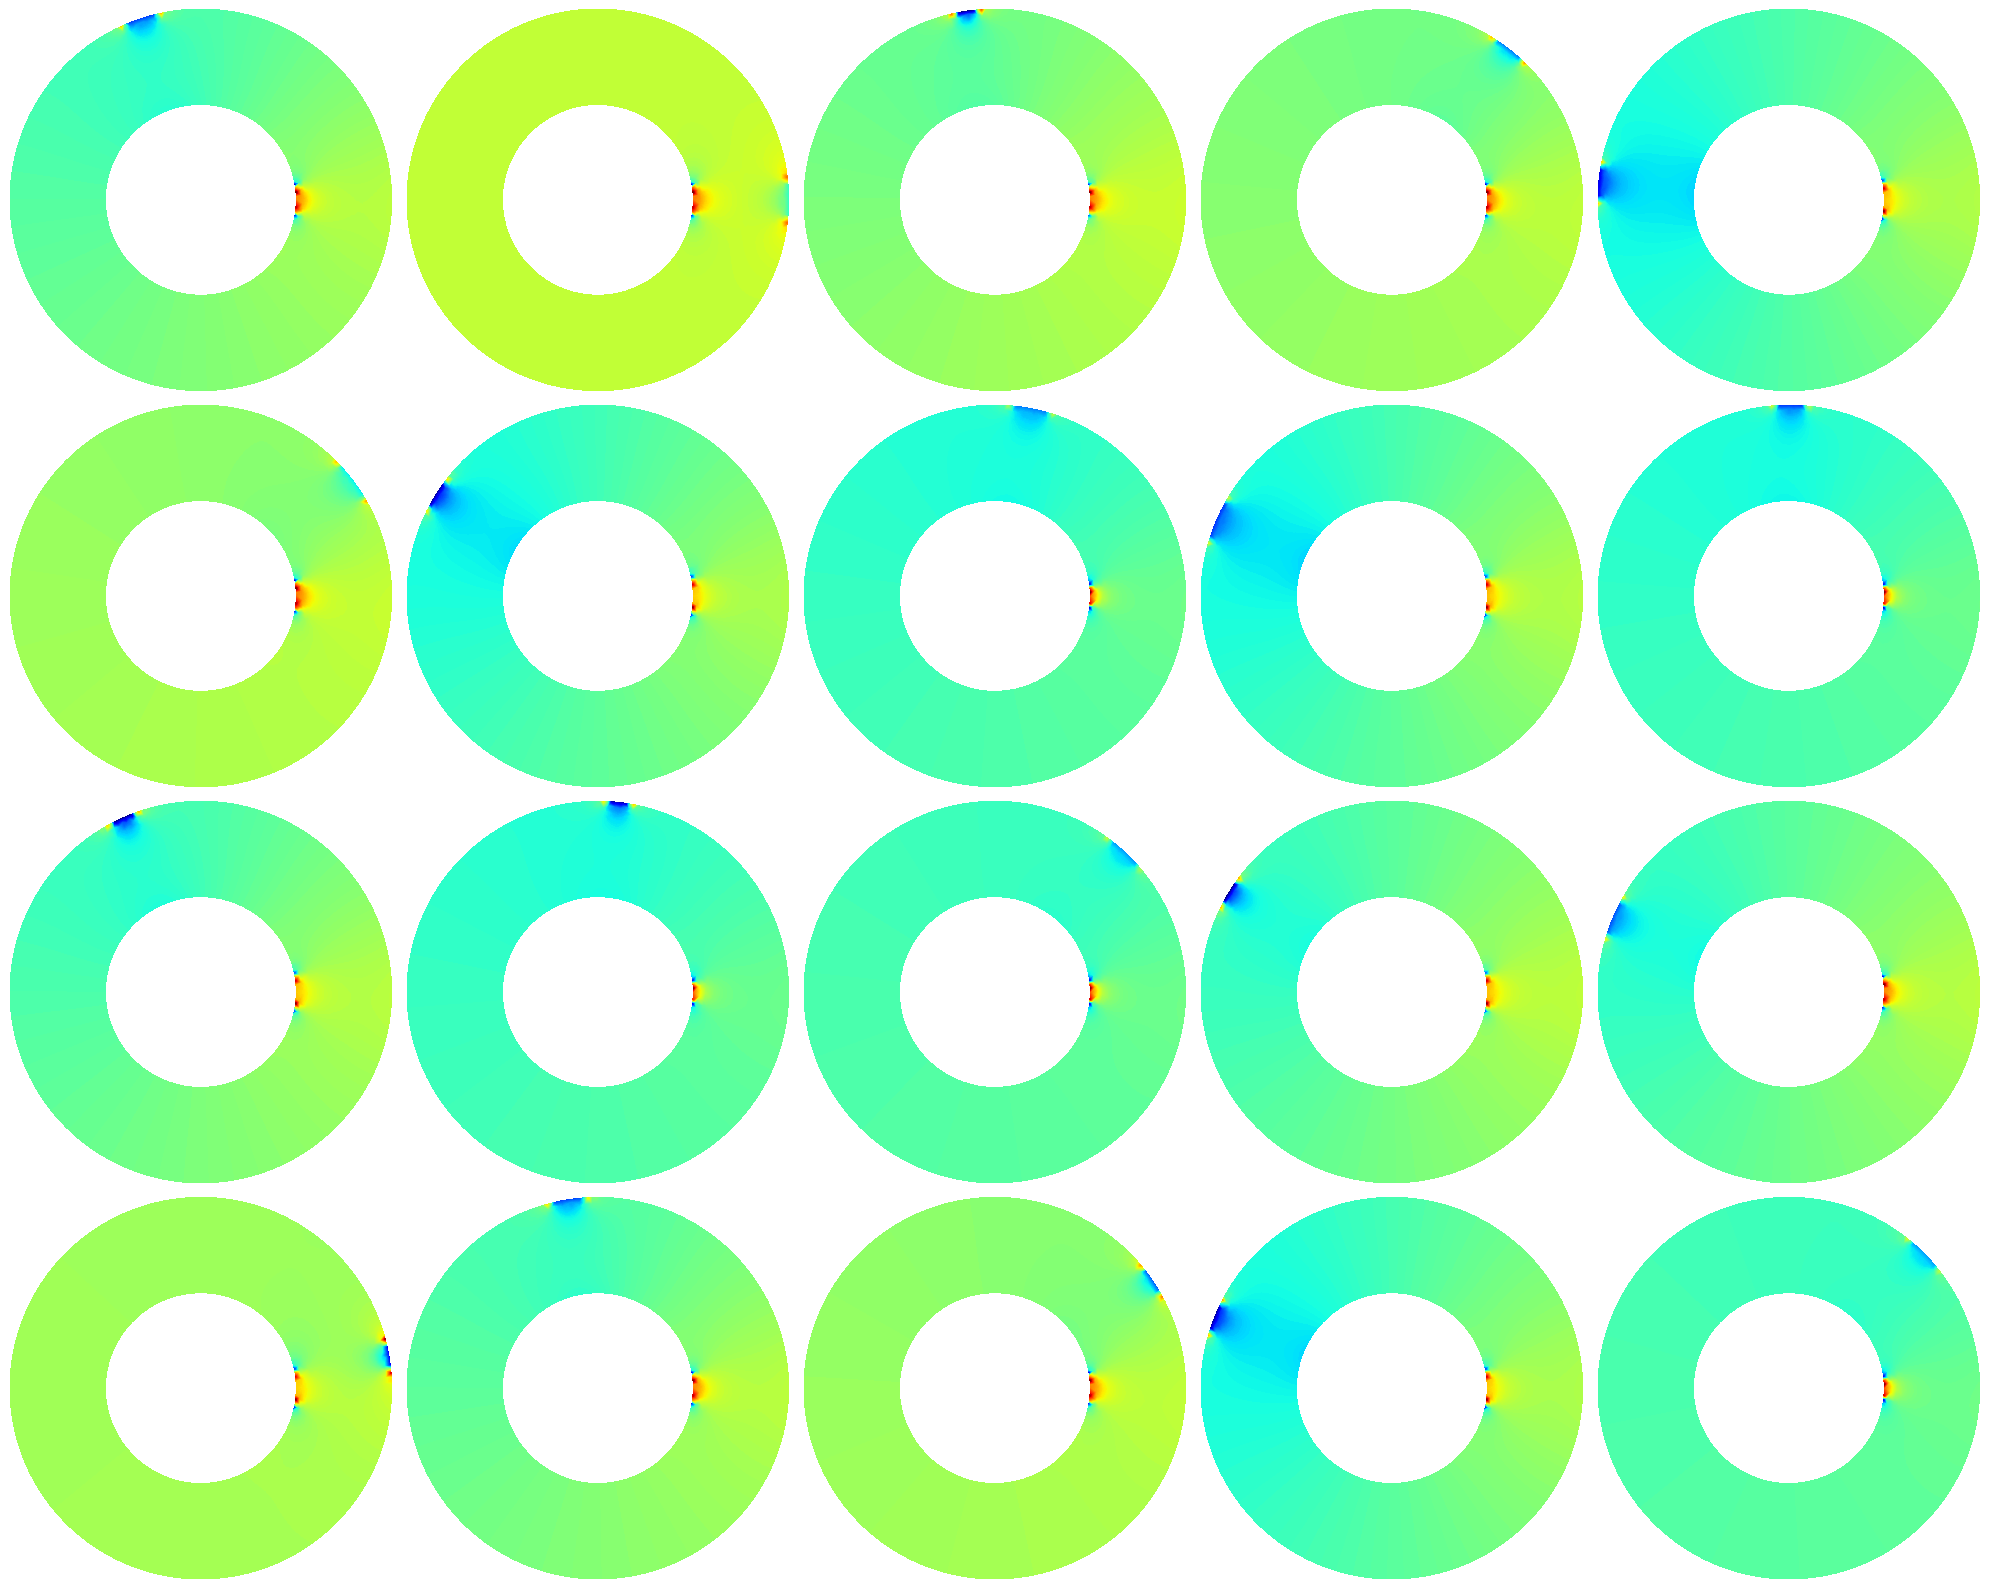

In [4]:
# Visualization
plt.figure(figsize = (4, 4))
fe.multiplot(pressure[0:20], (4, 5), Vh)
plt.tight_layout()
None

In [5]:
pressure.shape, mu.shape

((200, 3899), (200, 3))

In [6]:
# Pressure measurements for backward UQ
gdown.download(id = "1STu-gV96oB4Gqtv-kf9aenXODqJ7kdIq", output = "sensor_measurements.npz")
clc()

In [7]:
measurements = np.load("sensor_measurements.npz")
sensors_location, sensors_values = measurements['sensor_indices'], measurements['pressure_measurements']

print("Pressure values referring to the simulation in the above plot (just for comparison!):")
print(pressure[0][sensors_location])

print("\nPressure measurements recorded by the sensors (parameters unknown!):")
print(sensors_values)

Pressure values referring to the simulation in the above plot (just for comparison!):
[0.82332861 0.64023615 0.50120456 0.53532942 0.59885631 0.66380033
 0.72833138 0.82332861]

Pressure measurements recorded by the sensors (parameters unknown!):
[0.74090497 0.555422   0.40491081 0.44736759 0.51212018 0.57835533
 0.64417083 0.74090497]


In [ ]:
sensors_values.shape, sensors_location.shape

((8,), (8,))

## (a) Find the best-fitting simulation  

To start, **find the simulation in the dataset that best fits the measurements**, that is  

$$
i_* = \arg\min_{i=1, \dots, 200} \sum_{k=1}^{8} |s_k - p_{\boldsymbol{\mu}_i} (x_k, y_k)|^2 = \arg\min_{i=1, \dots, 200} \sum_{k=1}^{8} |s_k - p_{\boldsymbol{\mu}_i}^{(j_k)}|^2,
$$  

where $\mathbf{p}_{\boldsymbol{\mu}_i} = \begin{bmatrix} p_{\boldsymbol{\mu}_i}^{(1)} & \dots & p_{\boldsymbol{\mu}_i}^{(N_h)} \end{bmatrix}^\top$ and $j_1, \dots, j_8$ are suitable indices extracting the degrees of freedom associated to the sensors' location; see the auxiliary notebook. Which are the problem parameters associated to such simulation?  

In [8]:
# Brute force approach
def cost(pressure, sensors_location):
    residuals = sensors_values-pressure[sensors_location]
    return np.sum(residuals**2)


In [9]:
N = pressure.shape[0]

best_fit = 0
best_cost = cost(pressure[0], sensors_location)

for i in range(N):
    actual_cost = cost(pressure[i], sensors_location);
    if actual_cost<best_cost:
        best_fit = i;
        best_cost = actual_cost;
        print(best_fit, best_cost, sep=": ")

9: 0.024203941603303088
21: 0.0110137198697699
27: 0.0076669875323746965
67: 0.003632724098630246


In [10]:
print("Pressure values referring to the best simulation:")
print(pressure[best_fit][sensors_location])

print("Loss value:")
print(best_cost)

print("\nPressure measurements recorded by the sensors (parameters unknown!):")
print(sensors_values)

Pressure values referring to the best simulation:
[0.7542359  0.58025421 0.45232692 0.43140303 0.50112984 0.57555333
 0.64954348 0.7542359 ]
Loss value:
0.003632724098630246

Pressure measurements recorded by the sensors (parameters unknown!):
[0.74090497 0.555422   0.40491081 0.44736759 0.51212018 0.57835533
 0.64417083 0.74090497]


In [11]:
print("Problem parameters associated with the best simulation:")
print(mu[best_fit])

Problem parameters associated with the best simulation:
[2.15479511 0.07729257 0.09294283]


### (b) Fit a reduced-order model  

As a next step, we would like to improve our estimate at point (a) by **fitting a reduced-order model over the data provided** (rather than just using the dataset as an "atlas" for possible scenarios).  

- **Design and train a suitable reduced-order model** of your choice (POD-NN or DL-ROM) to approximate the map  

  $$
  \mathbb{R}^3 \ni \boldsymbol{\mu} \mapsto \mathbf{p}_{\boldsymbol{\mu}} \in \mathbb{R}^{3899}.
  $$  

  To this end, use 150 simulations for training and validation, keeping 50 for the testing phase. What is the average relative error of your model (in Euclidean norm) over the test set?  



In [12]:
# PRova a usanre un autonencoder cnn per dimensionality reduction e una nn cnn come rom, alla fine le simmetrie sono nei dati iniziali

In [13]:
from scipy.linalg import svd

In [14]:
data = pressure
data.shape

(200, 3899)

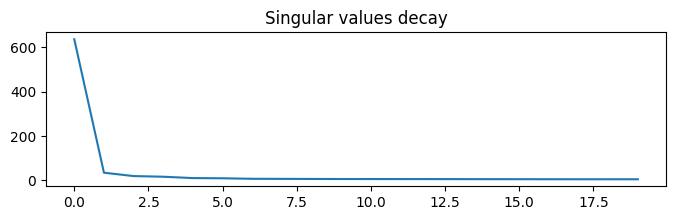

In [15]:
n_train = data.shape[0] - 50
n_test = 50
X, s, Yt = svd(data[:n_train].T, full_matrices = False)

plt.figure(figsize = (8, 2))
plt.plot(s[0:20])
plt.title("Singular values decay")
plt.show()

In [16]:
n = 10
V = X[:, :n]
V.shape

(3899, 10)

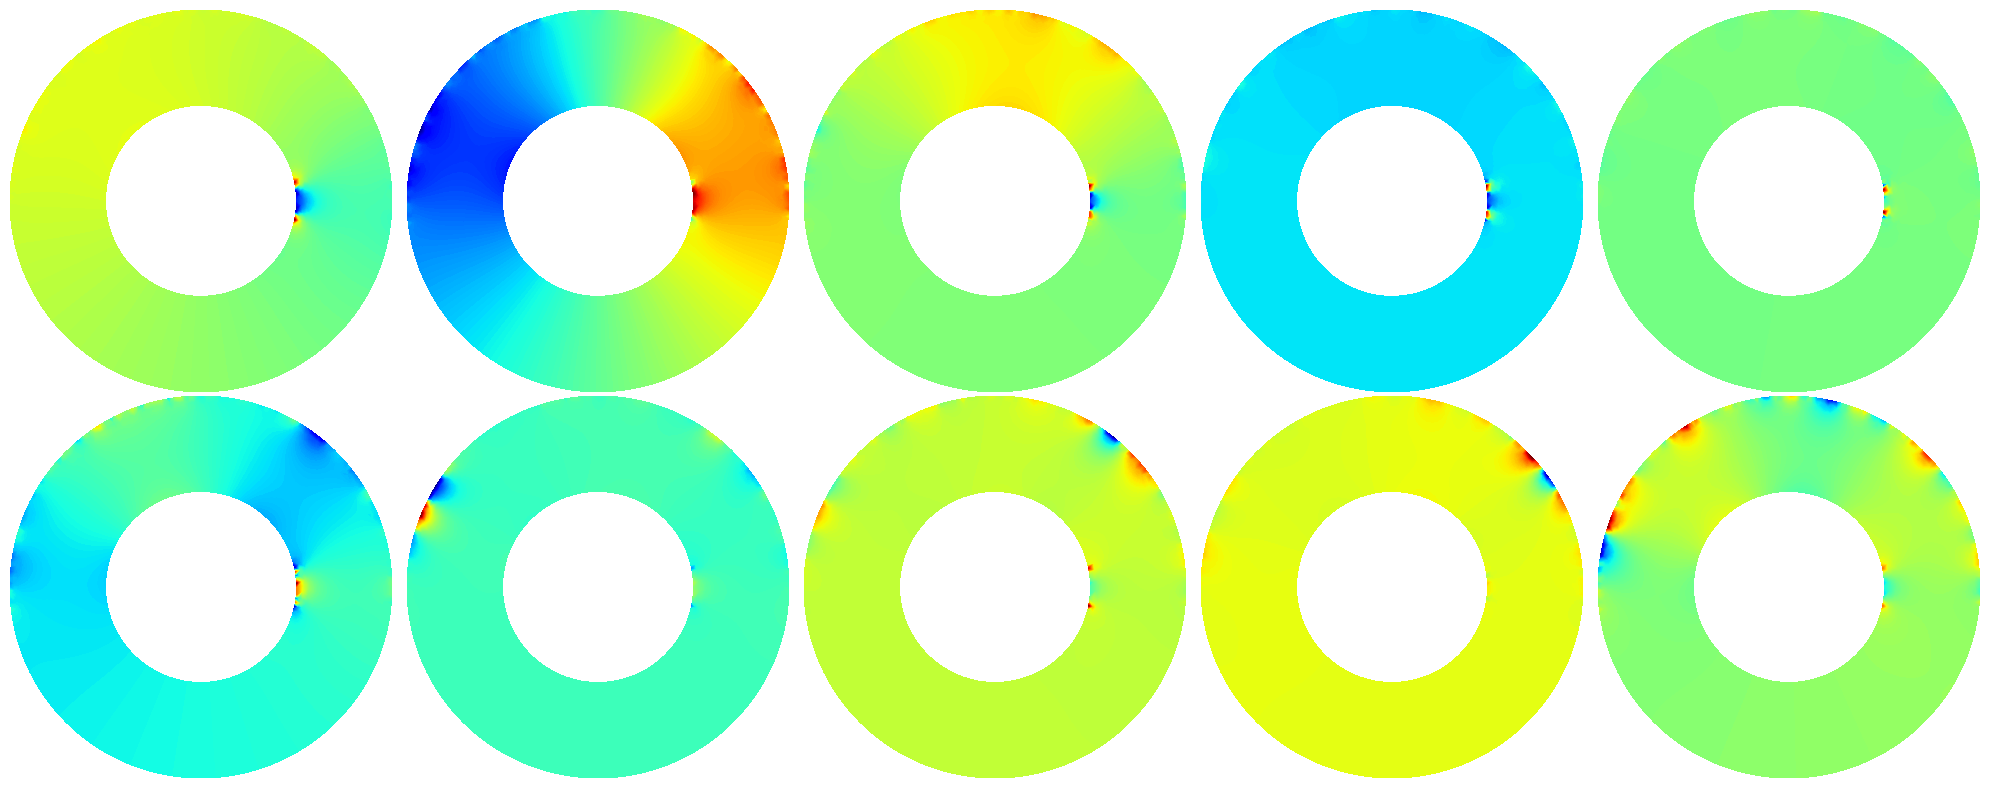

In [17]:
fe.multiplot(V.T, (2, 5), Vh)
plt.tight_layout()

In [18]:
data_proj = data @ V @ V.T
data_proj.shape

(200, 3899)

In [19]:
data.shape, data_proj.shape

((200, 3899), (200, 3899))

In [ ]:
#mre = lambda norm: lambda true, pred: (norm(true-pred)/norm(true)).mean()
#def euclidean(v):
    #return np.sqrt(np.sum(v**2))

In [20]:
from dlroms import*
mu, data, data_proj, V = dv.tensor(mu, data, data_proj, V)
l2 = L2(Vh)
l2.moveOn(dv)
clc()

In [21]:
data[n_train:].shape, data_proj[n_train:].shape

(torch.Size([50, 3899]), torch.Size([50, 3899]))

In [22]:
avg_proj_error = mre(l2)(data[n_train:], data_proj[n_train:])
print("Average projection error: %s." % num2p(avg_proj_error))

Average projection error: 3.37%.


In [23]:
c_mu = data @ V
c_mu.shape

torch.Size([200, 10])

In [24]:
p = mu.shape[1]
phi = Dense(p, 30) + Dense(30, 30) + Dense(30, n, activation = None)
model = DFNN(phi)
model.He()
model.train(mu, c_mu, ntrain = n_train-25, nvalid=25, epochs = 100, loss = mse(euclidean))

		Train		Valid		Test
Epoch 18:	3.56e+01	6.93e+01	1.14e+02.

>> ETA: 8.58s.

Training complete. Elapsed time: 1.86 seconds.


In [25]:
model.freeze()
uROM = model(mu[n_train:]) @ V.T
data[n_train:].shape, uROM.shape

(torch.Size([50, 3899]), torch.Size([50, 3899]))

In [26]:
avg_proj_error = mre(l2)(data[n_train:], uROM)
print("Average relative error of POD-NN: %s." % num2p(avg_proj_error))

Average relative error of POD-NN: 13.22%.


Text(0.5, 1.0, 'Simulation in the dataset,\n$\\mu=[2.73, 0.10, 0.06]$\n')

<Figure size 400x400 with 0 Axes>

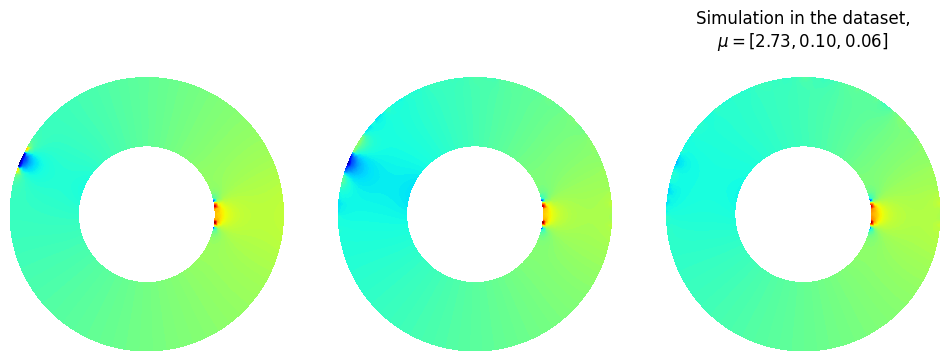

In [28]:
plt.figure(figsize = (4, 4))
i = 179
fe.multiplot([data[i], data_proj[i], model(mu[i]) @ V.T], (1,3), Vh)
plt.title("Simulation in the dataset,\n$\mu=[%.2f, %.2f, %.2f]$\n" % tuple(mu[i]))

### (c) Estimate the parameters using least squares  

Given any parameter vector $\boldsymbol{\mu}$, let $\tilde{\mathbf{p}}_{\boldsymbol{\mu}}$ denote the approximation of the pressure field obtained through the surrogate model. **Leveraging the reduced-order model, estimate the model parameters associated with the sensor measurements** by solving the following least-square problem  

$$
\boldsymbol{\mu}_{\text{lsq}} := \arg\min_{\boldsymbol{\mu} \in \Theta} \sum_{k=1}^{8} |s_k - \tilde{p}_{\boldsymbol{\mu}}^{(j_k)}|^2,
$$  

with $\Theta = [0, \pi] \times [0.05, 0.1]^2$ being the parameter space.  



In [29]:
import scipy

In [30]:
def rom_model(mu, sensors_location):
  mu = dv.tensor(mu)
  return  (model(mu) @ V.T)[sensors_location]


# Define the sum of squares function
def loss(mu, sensors_values, sensors_location):
    output = np.array(rom_model(mu, sensors_location))
    residuals = sensors_values - output
    return np.sum(residuals**2)


In [31]:
# Parameter space
bounds = [[0, np.pi], [0.05, 0.1], [0.05, 0.1]]

# Initial Guess
mu_0 = np.array([2, 0.075, 0.075])

# Perform LSQ fitting
result = scipy.optimize.minimize(loss, mu_0, args=(sensors_values, sensors_location), bounds=bounds)
mu_min = result.x  # Optimal parameters from LSQ
loss_min = result.fun  # Minimum sum of squares
sigma2 = loss_min / (8 - len(mu_min))  # Residual variance estimate

# Display LSQ results
print("LSQ Estimates:")
print(f"Mu1: {mu_min[0]:.4f}, Mu2: {mu_min[1]:.4f}, Mu3: {mu_min[2]:.4f} ")
print(f"Residual Variance (sigma^2): {sigma2:.6f}")
print(f"Loss min: {loss_min:.6f}")

LSQ Estimates:
Mu1: 2.0000, Mu2: 0.0750, Mu3: 0.0750 
Residual Variance (sigma^2): 0.070727
Loss min: 0.353633


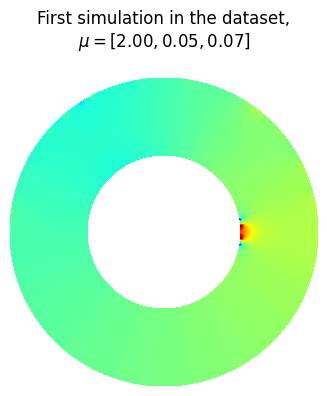

In [32]:
# Visualization
plt.figure(figsize = (4, 4))
fe.plot(model(dv.tensor([2, 0.0500, 0.0710 ])) @ V.T, Vh)
plt.title("First simulation in the dataset,\n$\mu=[%.2f, %.2f, %.2f]$\n" % tuple([2, 0.0500, 0.0710  ]))
None

### (d) Bayesian inference via Metropolis-Hastings  

Let us now consider a **Bayesian perspective**. Before the measurements are collected, we consider all parametric configurations to be equally likely; that is, we consider a uniform prior distribution over $\Theta$. Once the sensors collect the data, however, we can use this knowledge to update our beliefs and derive a (joint) posterior distribution for $\boldsymbol{\mu} = [\theta, \rho_1, \rho_2]$.  

- **After introducing all necessary assumptions**, exploit the surrogate model in combination with the **Metropolis-Hastings algorithm** to sample from the posterior distribution of $\boldsymbol{\mu} \mid s_1, \dots, s_8$. Use the latter to estimate the mean a posteriori, $\boldsymbol{\mu}_{\text{avg}}$, and compare it with the estimates at points (a) and (c).  

- **Bonus:** use the MCMC sample at point (d) to derive a **99% credibility interval** for $\theta$.


In [33]:
# MCMC with improved covariance
def run_mcmc_with_proposal(nsimu, npar, bmin, chol_qcov, sensors_values, sensors_location, sigma2):
    """
    Run the Random Walk Metropolis algorithm with a specified proposal covariance.

    Parameters:
    - nsimu: Number of MCMC simulations
    - npar: Number of parameters
    - bmin: Initial parameters (LS estimate)
    - chol_qcov: Cholesky decomposition of the proposal covariance
    - data: Input data
    - sigma2: Residual variance

    Returns:
    - chain: MCMC chain of sampled parameters
    - accept_rate: Acceptance rate of the MCMC algorithm
    """
    chain = np.zeros((nsimu, npar))
    chain[0, :] = bmin
    rej = 0
    ss = loss(bmin, sensors_values, sensors_location)

    for i in range(1, nsimu):
        newpar = chain[i - 1, :] + np.random.randn(1, npar) @ chol_qcov
        ss_new = loss(newpar.flatten(), sensors_values, sensors_location)

        # Metropolis acceptance ratio
        ratio = np.exp(-0.5 * (ss_new - ss) / sigma2)
        if np.random.rand() < ratio:  # Accept proposal
            chain[i, :] = newpar
            ss = ss_new
        else:  # Reject proposal
            chain[i, :] = chain[i - 1, :]
            rej += 1

    accept_rate = 1 - rej / nsimu
    return chain, accept_rate

In [35]:
from scipy.linalg import cholesky

In [36]:
# Initialize MCMC parameters
nsimu = 20000
npar = 3
chain = np.zeros((nsimu, npar))
qcov = 0.5e-3 * np.eye(npar)
chol_qcov = cholesky(qcov, lower=True)

# Start MCMC from LS estimate
oldpar = mu_min.copy()
chain[0, :] = oldpar
rej = 0  # Count rejections
ss = loss(oldpar, sensors_values, sensors_location)

# Run MCMC

# Random Walk Metropolis Algorithm
SS = np.zeros(nsimu)
SS[0] = ss


# Run MCMC
chain, accept_rate = run_mcmc_with_proposal(nsimu, npar, mu_min, chol_qcov, sensors_values, sensors_location, sigma2)
print("\nAcceptance Rate:", accept_rate)


Acceptance Rate: 0.36519999999999997


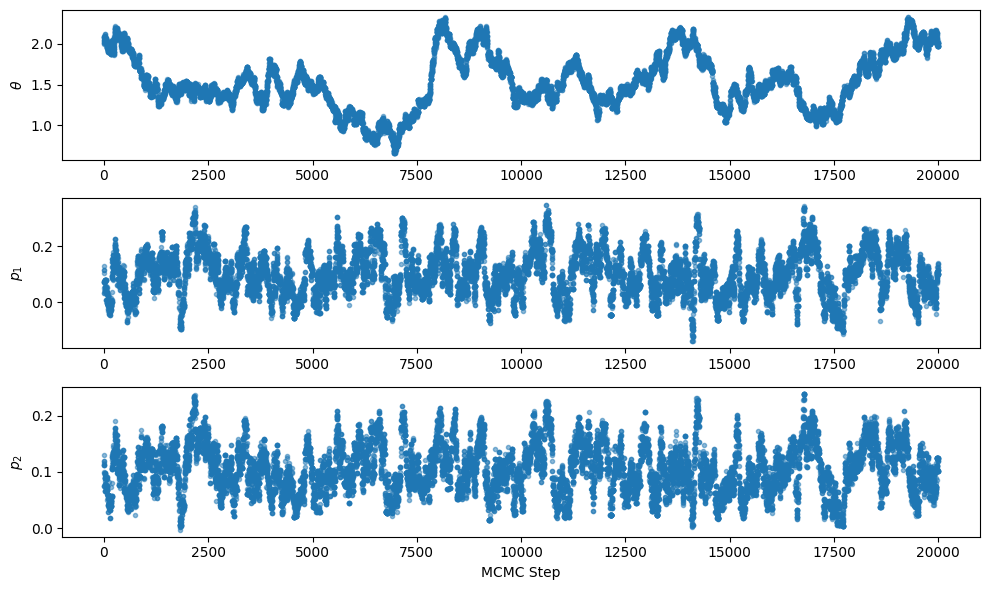

In [37]:
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(chain[:, 0], ".", alpha=0.5)
plt.ylabel(r"$\theta$")

plt.subplot(3, 1, 2)
plt.plot(chain[:, 1], ".", alpha=0.5)
plt.ylabel(r"$p_1$")

plt.subplot(3, 1, 3)
plt.plot(chain[:, 2], ".", alpha=0.5)
plt.ylabel(r"$p_2$")
plt.xlabel("MCMC Step")

plt.tight_layout()
plt.show()


In [38]:
posterior_mean = chain[10000:].mean(axis=0)
print(f"Posterior mean estimates: θ = {posterior_mean[0]}, p1 = {posterior_mean[1]}, p2 = {posterior_mean[2]}")


Posterior mean estimates: θ = 1.5792467089441948, p1 = 0.10034986090636666, p2 = 0.10530924824521615


# Other Approaches (drafts)


## Build a simple neural network for pod-nn using plain Pytorch

In [ ]:
import torch
from torch import nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [ ]:
# Build the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, p, n):
        super().__init__()
        self.leaky_relu_stack = nn.Sequential(
            nn.Linear(p, 30),
            nn.Linear(30, 30),
            nn.Linear(30, n),
        )

    def forward(self, x):
        output = self.leaky_relu_stack(x)
        return output

In [ ]:
p = 3
nn_model = NeuralNetwork(p,n).to(device)
print(nn_model)

NeuralNetwork(
  (leaky_relu_stack): Sequential(
    (0): Linear(in_features=3, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
  )
)


In [ ]:
c_mu[:n_train-25]

tensor([[-4.0200e+01,  1.9353e+00, -1.9374e+00,  ...,  1.8105e-01,
         -6.6452e-01, -2.1746e-01],
        [-2.2669e+01, -1.4589e+00,  5.1556e-01,  ...,  9.4188e-03,
         -1.8987e-01,  7.6865e-02],
        [-7.7776e+01, -1.6602e+00, -2.3120e-01,  ..., -1.6116e-01,
          3.2138e-01, -4.6908e-01],
        ...,
        [-2.1086e+01, -7.2439e-01, -1.6577e+00,  ..., -1.9127e-02,
         -1.3518e-01,  8.8960e-02],
        [-7.1382e+01, -4.3081e+00,  4.8983e-01,  ..., -1.2394e-01,
         -8.3537e-02, -2.5873e-01],
        [-2.4155e+01,  1.4921e+00, -1.9909e+00,  ..., -7.7815e-02,
          2.6445e-02, -1.8850e-02]])

In [ ]:
# Learning rate
learning_rate = 1e-2

train_set = mu[:n_train-25]
val_set = mu[n_train-25:n_train]
test_set = mu[n_train:]

# Stack the targets together
train_targets = c_mu[:n_train-25]
val_targets = c_mu[n_train-25:n_train]
test_targets = c_mu[n_train:]

# Define loss function
loss_fn = nn.MSELoss()

# Use full-batch gradient descent
optimizer = torch.optim.SGD(nn_model.parameters(), lr=learning_rate)  # Adjust learning rate as needed

# Training loop
train_losses = []
val_losses = []
num_epochs = 1000  # Set the number of epochs
for epoch in range(num_epochs):
    total_train_loss = 0.0
    for i in range(train_set.shape[0]):  # Loop over each sample
        sample = train_set[i].unsqueeze(0)  # Add batch dimension (1,4)
        target = train_targets[i].unsqueeze(0)  # Target shape (1,2)

        # Forward pass
        output = nn_model(sample)

        # Compute loss
        loss = loss_fn(output, target)
        total_train_loss += loss.item()

        # Backward pass & optimization step
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients / Backpropagation
        optimizer.step()       # Update model / Gradient Descent


    # Compute average training loss
    avg_train_loss = total_train_loss / train_set.shape[0]
    train_losses.append(avg_train_loss)


    # Validation: Evaluate on the full validation set
    nn_model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        val_outputs = nn_model(val_set)
        val_loss = loss_fn(val_outputs, val_targets).item()  # Compute MSE loss
        val_losses.append(val_loss)

    nn_model.train()  # Switch back to training mode

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

Epoch [1/1000], Train Loss: 26.628582, Val Loss: 24.227505
Epoch [2/1000], Train Loss: 17.561905, Val Loss: 21.801243
Epoch [3/1000], Train Loss: 16.984188, Val Loss: 21.157696
Epoch [4/1000], Train Loss: 16.671214, Val Loss: 20.776730
Epoch [5/1000], Train Loss: 16.447167, Val Loss: 20.475559
Epoch [6/1000], Train Loss: 16.256261, Val Loss: 20.204399
Epoch [7/1000], Train Loss: 16.078130, Val Loss: 19.944168
Epoch [8/1000], Train Loss: 15.903914, Val Loss: 19.685860
Epoch [9/1000], Train Loss: 15.729195, Val Loss: 19.424829
Epoch [10/1000], Train Loss: 15.551870, Val Loss: 19.159113
Epoch [11/1000], Train Loss: 15.371455, Val Loss: 18.888798
Epoch [12/1000], Train Loss: 15.188396, Val Loss: 18.614933
Epoch [13/1000], Train Loss: 15.002879, Val Loss: 18.337873
Epoch [14/1000], Train Loss: 14.813666, Val Loss: 18.055954
Epoch [15/1000], Train Loss: 14.617831, Val Loss: 17.765488
Epoch [16/1000], Train Loss: 14.411246, Val Loss: 17.461399
Epoch [17/1000], Train Loss: 14.189109, Val Loss:

In [ ]:
# Set model to evaluation mode
nn_model.eval()

# No gradient computation during evaluation
with torch.no_grad():
    test_predictions = nn_model(test_set)  # Get model predictions
    mse_test = loss_fn(test_targets, test_predictions)

# Print MSE
print(f"Test MSE: {mse_test:.6f}")

NameError: name 'nn_model' is not defined

In [ ]:
nn_model(test_set).shape

NameError: name 'nn_model' is not defined

In [ ]:
model.freeze()
uROM = nn_model(test_set) @ V.T
data[n_train:].shape, uROM.shape

NameError: name 'nn_model' is not defined

In [ ]:
c_mu[n_train:].shape, nn_model(test_set).shape

(torch.Size([50, 30]), torch.Size([50, 30]))

In [ ]:
torch.max(c_mu[n_train:]-nn_model(test_set))

tensor(17.2067, grad_fn=<MaxBackward1>)

In [ ]:
avg_proj_error = mre(l2)(test_targets, model(test_set))

NameError: name 'test_targets' is not defined

In [ ]:
# Set model to evaluation mode
nn_model.eval()

# No gradient computation during evaluation
with torch.no_grad():
    test_predictions = nn_model(test_set) @ V.T  # Get model predictions
    mse_test = loss_fn(data[n_train:], test_predictions)

# Print MSE
print(f"Test MSE: {mse_test:.6f}")

Test MSE: 0.016498


## Non linear dimensionality reduction (autoencoder instead of pod)


In [ ]:
latent = 15
nh = data.shape[1]
encoder = Dense(nh, 50) + Dense(50, latent)
decoder = Dense(latent, 50) + Dense(50, 100) + Dense(100, nh, activation = None)
autoencoder = DFNN(encoder + decoder)
autoencoder.He()
autoencoder.train(data, data, ntrain = n_train, epochs = 100, loss = mse(l2)) #NOTE MSE IN L2. IF USE EUCLIDEAN YOU OBTAIN ACCURATE RESULT AROUND THE CILINDER BUT NOT EVERYWHERE ELSE

		Train		Test
Epoch 100:	1.46e-03	1.76e-03.

>> ETA: 4.14s.

Training complete. Elapsed time: 6 minutes 54.03 seconds.


In [ ]:
autoencoder.freeze()
avg_proj_error = mre(l2)(data[n_train:], autoencoder(data[n_train:]))
print("Average relative error of POD-NN: %s." % num2p(avg_proj_error))

Average relative error of POD-NN: 3.46%.


In [ ]:
from dlroms.dnns import Fourier

nu = encoder(data)
nu_mean, nu_std = nu[:n_train].mean(axis = 0), nu[:n_train].var(axis = 0).sqrt()
nu = (nu - nu_mean)/nu_std

fmodes = 10
phi = DFNN(Fourier(fmodes, which = [2]) + Dense(p+1+2*fmodes, 500) + Dense(500, latent, activation = None))

phi.He()
phi.train(mu, nu, ntrain = n_train, epochs = 500, loss = mse(euclidean))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (150x23 and 24x500)

In [ ]:
dlrom = lambda mt: decoder(phi(mt)*nu_std + nu_mean)
num2p(error(u[n_train:], dlrom(mut[n_train:])))

## Non linear dimensionality reduction with convolutional autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self, input_dim=3899, latent_dim=10):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2),
            nn.ReLU()
        )

        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(64 * ((input_dim // 8)+1), latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 64 * ((input_dim // 8)+1))
        self.unflatten = nn.Unflatten(1, (64, ((input_dim // 8)+1)))

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=5, stride=2, padding=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=5, stride=2, padding=2, output_padding=0),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        #print("Shape before flattening:", x.shape)  # Debugging print
        x = self.flatten(x)
        #print("Shape after flattening:", x.shape)  # Debugging print
        x = self.fc_enc(x)
        #print("Shape before fc_enc:", x.shape)  # Debugging print
        x = self.fc_dec(x)
        #print("Shape after fc_enc:", x.shape)  # Debugging print
        x = self.unflatten(x)
        #print("Shape before fc_dec:", x.shape)  # Debugging print
        x = self.decoder(x)
        #print("Shape after fc_dec:", x.shape)  # Debugging print
        # Adjust final output size to 3899 if necessary
        if x.size(2) != 3899:
            x = torch.nn.functional.interpolate(x, size=(3899), mode='linear', align_corners=False)
            #print("Adjusted output size:", x.shape)
        return x

In [ ]:
# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)


# Define loss and optimizer
cost = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_autoencoder(dataloader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for data in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = cost(outputs, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")


In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to PyTorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx].unsqueeze(0)  # Add channel dimension
        return x  # Shape should be [1, 3899],


In [ ]:
data = torch.from_numpy(pressure[:150])
data.shape

torch.Size([150, 3899])

In [ ]:
# Create Dataset and DataLoader
dataset = CustomDataset(data)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)  # Adjust batch size as needed

<ipython-input-164-2eb4231c4c77>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)  # Convert to PyTorch tensor


In [ ]:
# Train the autoencoder
train_autoencoder(dataloader, num_epochs=40)

Epoch [1/40], Loss: 0.2197
Epoch [2/40], Loss: 0.0949
Epoch [3/40], Loss: 0.0481
Epoch [4/40], Loss: 0.0307
Epoch [5/40], Loss: 0.0193
Epoch [6/40], Loss: 0.0141
Epoch [7/40], Loss: 0.0123
Epoch [8/40], Loss: 0.0101
Epoch [9/40], Loss: 0.0088
Epoch [10/40], Loss: 0.0085
Epoch [11/40], Loss: 0.0075
Epoch [12/40], Loss: 0.0072
Epoch [13/40], Loss: 0.0067
Epoch [14/40], Loss: 0.0064
Epoch [15/40], Loss: 0.0061
Epoch [16/40], Loss: 0.0058
Epoch [17/40], Loss: 0.0054
Epoch [18/40], Loss: 0.0051
Epoch [19/40], Loss: 0.0049
Epoch [20/40], Loss: 0.0044
Epoch [21/40], Loss: 0.0041
Epoch [22/40], Loss: 0.0041
Epoch [23/40], Loss: 0.0060
Epoch [24/40], Loss: 0.0048
Epoch [25/40], Loss: 0.0052
Epoch [26/40], Loss: 0.0048
Epoch [27/40], Loss: 0.0045
Epoch [28/40], Loss: 0.0055
Epoch [29/40], Loss: 0.0047
Epoch [30/40], Loss: 0.0041
Epoch [31/40], Loss: 0.0035
Epoch [32/40], Loss: 0.0035
Epoch [33/40], Loss: 0.0033
Epoch [34/40], Loss: 0.0033
Epoch [35/40], Loss: 0.0032
Epoch [36/40], Loss: 0.0031
E

In [ ]:
test_set = pressure[150:]

In [ ]:
test_loader = DataLoader(dataset, batch_size=16, shuffle=True)  # Adjust batch size as needed

In [ ]:
# MRE Calculation
def calculate_mre(true_values, predicted_values):
    # Ensure values are non-zero to avoid division by zero
    true_values = true_values + 1e-8  # Add small epsilon to prevent divide by zero
    mre = torch.mean(torch.abs(true_values - predicted_values) / torch.abs(true_values))
    return mre.item()

# Assuming test_loader is already defined (Dataloader for test set)
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    total_mre = 0
    count = 0

    with torch.no_grad():  # No need to compute gradients during testing
        for data in test_loader:
            # Forward pass
            output = model(data)
            # Calculate MRE for the current batch
            mre = calculate_mre(data, output)
            total_mre += mre
            count += 1

    avg_mre = total_mre / count
    return avg_mre

# Example usage
# Assuming you have a DataLoader for the test set (test_loader)
# model = SimpleModel()
# Test the model and print the average MRE
avg_mre = test_model(model, test_loader)
print(f"Average MRE: {avg_mre:.4f}")

Average MRE: 39631.2954


In [ ]:
tmp = []
output = []
for data in test_loader:
  # Forward pass
  tmp.append(data)
  output.append(model(data))

In [ ]:
output[0][0], data[0][0]

(tensor([[0.5945, 0.5827, 0.6141,  ..., 0.5015, 0.4612, 0.5061]],
        grad_fn=<SelectBackward0>),
 tensor([0.7847, 0.7851, 0.7811,  ..., 0.4350, 0.4344, 0.4347]))

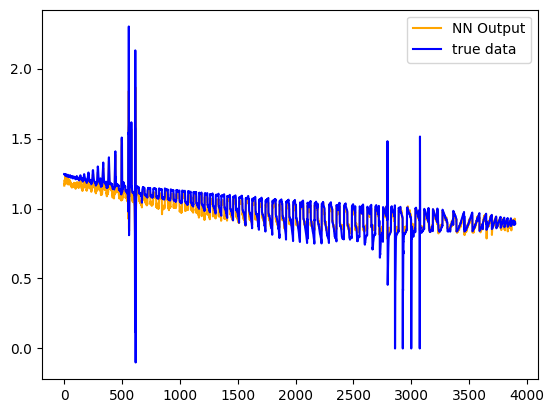

In [ ]:
i = 5

plt.plot(output[i].detach().numpy()[0][0], label='NN Output', color='orange')
plt.plot(data[i].detach().numpy()[0], label='true data', color='blue')
plt.legend()
plt.show()

## Custom autoencoder architecture (enriching the latent space with the parameter vector)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, param_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.param_dim = param_dim

        # Encoder: Maps input simulation to a latent vector
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 50),
            #nn.ReLU(),
            nn.Linear(50, 30),
            #nn.ReLU(),
            nn.Linear(30, latent_dim)  # Latent representation
        )

        # Fusion Layer: Combines latent space with parameters
        self.fusion_layer = nn.Sequential(
            nn.Linear(latent_dim + param_dim, latent_dim),
            nn.ReLU()
        )

        # Decoder: Reconstructs simulation from fused latent space
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 30),
            #nn.ReLU(),
            nn.Linear(30, 50),
            #nn.ReLU(),
            nn.Linear(50, input_dim)  # Output same shape as input
        )

        # Parameter Predictor (Optional)
        self.param_predictor = nn.Linear(latent_dim, param_dim)  # Predicts parameters from latent space

    def forward(self, simulation, params):
        # Encode simulation data into latent space
        latent_vector = self.encoder(simulation)

        # Fuse latent space with parameters
        fused_latent = self.fusion_layer(torch.cat([latent_vector, params], dim=-1))

        # Decode back to simulation
        reconstructed_simulation = self.decoder(fused_latent)

        # Predict parameters (optional)
        predicted_params = self.param_predictor(latent_vector)

        return reconstructed_simulation, fused_latent, predicted_params

    def extract_latent(self, simulation, params):
        """ Extracts the pure latent space and the fused latent space. """
        latent_vector = self.encoder(simulation)  # Encoded representation
        fused_latent = self.fusion_layer(torch.cat([latent_vector, params], dim=-1))  # Fused representation
        return latent_vector, fused_latent  # Return both representations

    def reduced_model(self, latent_vector):
        # Decode back to simulation
        reconstructed_simulation = self.decoder(latent_vector)
        return reconstructed_simulation


In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self, input_dim=3899, latent_dim=10):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2),
            nn.ReLU()
        )

        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(64 * ((input_dim // 8)+1), latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 64 * ((input_dim // 8)+1))
        self.unflatten = nn.Unflatten(1, (64, ((input_dim // 8)+1)))

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=5, stride=2, padding=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=5, stride=2, padding=2, output_padding=0),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        #print("Shape before flattening:", x.shape)  # Debugging print
        x = self.flatten(x)
        #print("Shape after flattening:", x.shape)  # Debugging print
        x = self.fc_enc(x)
        #print("Shape before fc_enc:", x.shape)  # Debugging print
        x = self.fc_dec(x)
        #print("Shape after fc_enc:", x.shape)  # Debugging print
        x = self.unflatten(x)
        #print("Shape before fc_dec:", x.shape)  # Debugging print
        x = self.decoder(x)
        #print("Shape after fc_dec:", x.shape)  # Debugging print
        # Adjust final output size to 3899 if necessary
        if x.size(2) != 3899:
            x = torch.nn.functional.interpolate(x, size=(3899), mode='linear', align_corners=False)
            #print("Adjusted output size:", x.shape)
        return x

In [ ]:
def autoencoder_loss(true_simulation, predicted_simulation, true_params, predicted_params, lambda1=1.0):
    recon_loss = torch.mean((true_simulation - predicted_simulation) ** 2)  # MSE reconstruction loss
    param_loss = torch.mean((true_params - predicted_params) ** 2)  # MSE for parameter prediction
    total_loss = recon_loss + lambda1 * param_loss
    return total_loss


In [ ]:
# Define hyperparameters
input_dim = data.shape[1]  # Adjust based on your simulation data size
param_dim = mu.shape[1]    # Number of known parameters (angle, width)
latent_dim = 5  # Size of latent space

# Instantiate model
autoencoder = Autoencoder(input_dim, param_dim, latent_dim)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Ttraining data
train_sim = torch.tensor(pressure[:n_train], dtype=torch.float32)
test_sim = torch.tensor(pressure[:n_train], dtype=torch.float32)
train_param = torch.tensor(mu[:n_train], dtype=torch.float32)
test_param = torch.tensor(mu[:n_train], dtype=torch.float32)

In [ ]:
batch_size = 1
num_samples = train_sim.shape[0]
num_batches = num_samples // batch_size

for epoch in range(num_epochs):
    for i in range(num_batches):
        # Define batch slices
        start = i * batch_size
        end = start + batch_size

        sim_batch = train_sim[start:end]
        param_batch = train_param[start:end]

        optimizer.zero_grad()

        # Forward pass
        reconstructed_sim, fused_latent, predicted_params = autoencoder(sim_batch, param_batch)

        # Compute loss
        loss = autoencoder_loss(sim_batch, reconstructed_sim, param_batch, predicted_params)

        # Backpropagation
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/50], Loss: 0.7246
Epoch [2/50], Loss: 0.3942
Epoch [3/50], Loss: 0.2139
Epoch [4/50], Loss: 0.1167
Epoch [5/50], Loss: 0.0401
Epoch [6/50], Loss: 0.0206
Epoch [7/50], Loss: 0.0148
Epoch [8/50], Loss: 0.0116
Epoch [9/50], Loss: 0.0091
Epoch [10/50], Loss: 0.0074
Epoch [11/50], Loss: 0.0068
Epoch [12/50], Loss: 0.0070
Epoch [13/50], Loss: 0.0090
Epoch [14/50], Loss: 0.0119
Epoch [15/50], Loss: 0.0135
Epoch [16/50], Loss: 0.0134
Epoch [17/50], Loss: 0.0120
Epoch [18/50], Loss: 0.0143
Epoch [19/50], Loss: 0.0201
Epoch [20/50], Loss: 0.0225
Epoch [21/50], Loss: 0.0490
Epoch [22/50], Loss: 0.0464
Epoch [23/50], Loss: 0.0369
Epoch [24/50], Loss: 0.0427
Epoch [25/50], Loss: 0.0340
Epoch [26/50], Loss: 0.0967
Epoch [27/50], Loss: 0.1305
Epoch [28/50], Loss: 0.0125
Epoch [29/50], Loss: 0.0291
Epoch [30/50], Loss: 0.0065
Epoch [31/50], Loss: 0.0108
Epoch [32/50], Loss: 0.0167
Epoch [33/50], Loss: 0.0311
Epoch [34/50], Loss: 0.0128
Epoch [35/50], Loss: 0.0359
Epoch [36/50], Loss: 0.0368
E

In [ ]:
reconstructed_sim, fused_latent, predicted_params = autoencoder(test_sim, test_param)

In [ ]:
reconstructed_sim.shape, fused_latent.shape, predicted_params.shape

(torch.Size([150, 3899]), torch.Size([150, 5]), torch.Size([150, 3]))

In [ ]:
avg_proj_error = mre(l2)(test_sim, reconstructed_sim)
print("Average relative error: %s." % num2p(avg_proj_error))

Average relative error: 7.66%.


In [ ]:
fused_latent_data = autoencoder(torch.tensor(pressure, dtype=torch.float32), torch.tensor(mu, dtype=torch.float32))[1]
fused_latent_data_train = fused_latent_data[:n_train].detach()
fused_latent_data_test = fused_latent_data[n_train:].detach()

In [ ]:
mu_train = torch.tensor(mu[:n_train], dtype=torch.float32)
mu_test = torch.tensor(mu[n_train:], dtype=torch.float32)

In [ ]:
mu_train.shape, fused_latent_data_train.shape, mu_test.shape, fused_latent_data_test.shape

(torch.Size([150, 3]),
 torch.Size([150, 10]),
 torch.Size([50, 3]),
 torch.Size([50, 10]))

In [ ]:
param_dim = mu_train.shape[1]
latent_dim = fused_latent_data_train.shape[1]

phi = Dense(param_dim, 30) + Dense(30, 30) + Dense(30, latent_dim, activation = None)
model = DFNN(phi)
model.He()
model.train(mu_train, fused_latent_data_train, ntrain = n_train, epochs = 50, loss = mse(euclidean))

		Train		Test
Epoch 50:	5.45e-02	nan.

>> ETA: 0.09s.

Training complete. Elapsed time: 4.48 seconds.


In [ ]:
reconstructed_latent_vector = model(mu_test)
reconstructed_latent_vector.shape

torch.Size([50, 10])

In [ ]:
model.freeze()

In [ ]:
fused_latent_data_test.shape

torch.Size([50, 10])

In [ ]:
torch.mean((fused_latent_data_test - reconstructed_latent_vector) ** 2)  # MSE

tensor(0.0068, grad_fn=<MeanBackward0>)

In [ ]:
fused_data = model(torch.tensor(mu, dtype=torch.float32))

In [ ]:
uRom = autoencoder.reduced_model(fused_data)

In [ ]:
avg_proj_error = mre(l2)(torch.tensor(pressure, dtype=torch.float32), uRom)
print("Average relative error of POD-NN: %s." % num2p(avg_proj_error))

Average relative error of POD-NN: 12.88%.
